This notebook was part of [RLSS 2019](https://rlss.inria.fr/) summer school ([Github](https://github.com/yfletberliac/rlss-2019)).

# Model-Based Reinforcement Learning

## Principle
We consider the optimal control problem of an MDP with a **known** reward function $R$ and subject to **unknown deterministic** dynamics $s_{t+1} = f(s_t, a_t)$:

$$\max_{(a_0,a_1,\dotsc)} \sum_{t=0}^\infty \gamma^t R(s_t,a_t)$$

In **model-based reinforcement learning**, this problem is solved in **two steps**:
1. **Model learning**:
We learn a model of the dynamics $f_\theta \simeq f$ through regression on interaction data.
2. **Planning**:
We leverage the dynamics model $f_\theta$ to compute the optimal trajectory $$\max_{(a_0,a_1,\dotsc)} \sum_{t=0}^\infty \gamma^t R(\hat{s}_t,a_t)$$ following the learnt dynamics $\hat{s}_{t+1} = f_\theta(\hat{s}_t, a_t)$.

(We can easily extend to unknown rewards and stochastic dynamics, but we consider the simpler case in this notebook for ease of presentation)


## Motivation

### Sparse rewards
* In model-free reinforcement learning, we only obtain a reinforcement signal when encountering rewards. In environment with **sparse rewards**, the chance of obtaining a reward randomly is **negligible**, which prevents any learning.
* However, even in the **absence of rewards** we still receive a **stream of state transition data**. We can exploit this data to learn about the task at hand.

### Complexity of the policy/value vs dynamics:
Is it easier to decide which action is best, or to predict what is going to happen?
* Some problems can have **complex dynamics** but a **simple optimal policy or value function**. For instance, consider the problem of learning to swim. Predicting the movement requires understanding fluid dynamics and vortices while the optimal policy simply consists in moving the limbs in sync.
* Conversely, other problems can have **simple dynamics** but **complex policies/value functions**. Think of the game of Go, its rules are simplistic (placing a stone merely changes the board state at this location) but the corresponding optimal policy is very complicated.

Intuitively, model-free RL should be applied to the first category of problems and model-based RL to the second category.

### Inductive bias
Oftentimes, real-world problems exhibit a particular **structure**: for instance, any problem involving motion of physical objects will be **continuous**. It can also be **smooth**, **invariant** to translations, etc. This knowledge can then be incorporated in machine learning models to foster efficient learning. In contrast, there can often be **discontinuities** in the policy decisions or value function: e.g. think of a collision vs near-collision state.

###  Sample efficiency
Overall, it is generally recognized that model-based approaches tend to **learn faster** than model-free techniques (see e.g. [[Sutton, 1990]](http://papersdb.cs.ualberta.ca/~papersdb/uploaded_files/paper_p160-sutton.pdf.stjohn)).

### Interpretability
In real-world applications, we may want to know **how a policy will behave before actually executing it**, for instance for **safety-check** purposes. However, model-free reinforcement learning only recommends which action to take at current time without being able to predict its consequences. In order to obtain the trajectory, we have no choice but executing the policy. In stark contrast, model-based methods a more interpretable in the sense that we can probe the policy for its intended (and predicted) trajectory.

## Our challenge: Automated Parking System

We consider the **parking-v0** task of the [highway-env](https://github.com/eleurent/highway-env) environment. It is a **goal-conditioned continuous control** task where an agent **drives a car** by controlling the gaz pedal and steering angle and must **park in a given location** with the appropriate heading.

This MDP has several properties wich justifies using model-based methods:
* The policy/value is highly dependent on the goal which adds a significant level of complexity to a model-free learning process, whereas the dynamics are completely independent of the goal and hence can be simpler to learn.
* In the context of an industrial application, we can reasonably expect for safety concerns that the planned trajectory is required to be known in advance, before execution.

###  Warming up
We start with a few useful installs and imports:

In [ ]:
# Install environment and visualization dependencies
%%capture
!apt install -y python3-opengl
!apt install -y xvfb
!apt install -y ffmpeg

In [ ]:
!pip install -q git+https://github.com/eleurent/highway-env
!pip install -q gym pyvirtualdisplay

In [ ]:
# Environment
import gymnasium as gym
import highway_env

# Models and computation
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from collections import namedtuple
# torch.set_default_tensor_type("torch.cuda.FloatTensor")

# Visualization
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tnrange
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from gym.wrappers.record_video import RecordVideo
import base64

# IO
from pathlib import Path

We also define a simple helper function for visualization of episodes:

In [ ]:
display = Display(visible=0, size=(1400, 900))
display.start()

def show_videos(path="video"):
    html = []
    for mp4 in Path(path).glob("*.mp4"):
        video_b64 = base64.b64encode(mp4.read_bytes())
        html.append('''<video alt="{}" autoplay
                      loop controls style="height: 400px;">
                      <source src="data:video/mp4;base64,{}" type="video/mp4" />
                 </video>'''.format(mp4, video_b64.decode('ascii')))
    ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Let's try it!

Make the environment, and run an episode with random actions:

In [ ]:
env = gym.make("parking-v0", render_mode='rgb_array')
env = RecordVideo(env, './video',  episode_trigger = lambda episode_number: True)
env.reset()
done = False
while not done:
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
env.close()
show_videos()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


The environment is a `GoalEnv`, which means the agent receives a dictionary containing both the current `observation` and the `desired_goal` that conditions its policy.

In [ ]:
print("Observation format:", obs)

Observation format: OrderedDict([('observation', array([0.11017459, 0.17822765, 0.31931208, 0.57462354, 0.48573218,
       0.87410769])), ('achieved_goal', array([0.11017459, 0.17822765, 0.31931208, 0.57462354, 0.48573218,
       0.87410769])), ('desired_goal', array([-1.000000e-01,  1.400000e-01,  0.000000e+00,  0.000000e+00,
        6.123234e-17,  1.000000e+00]))])


There is also an `achieved_goal` that won't be useful here (it only serves when the state and goal spaces are different, as a projection from the observation to the goal space).

Alright! We are now ready to apply the model-based reinforcement learning paradigm.

## Experience collection
First, we randomly interact with the environment to produce a batch of experiences

$$D = \{s_t, a_t, s_{t+1}\}_{t\in[1,N]}$$

In [ ]:
Transition = namedtuple('Transition', ['state', 'action', 'next_state'])

def collect_interaction_data(env, size=1000, action_repeat=2):
    data, done = [], True
    for _ in tnrange(size // action_repeat, desc="Collect interaction data"):
        action = env.action_space.sample()
        for _ in range(action_repeat):
            previous_obs = env.reset()[0] if done else obs
            obs, reward, done, info = env.step(action)
            # print(previous_obs[0])
            data.append(Transition(torch.Tensor(previous_obs["observation"]),
                                   torch.Tensor(action),
                                   torch.Tensor(obs["observation"])))
    return data

data_size = 2000
data = collect_interaction_data(env, size=data_size)
assert len(data) == data_size
assert isinstance(data[0], Transition)
assert all([isinstance(field, torch.Tensor) for field in data[0]])
print("Sample transition:", data[0])

<ipython-input-6-a2696c37564a>:5: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for _ in tnrange(size // action_repeat, desc="Collect interaction data"):


Collect interaction data:   0%|          | 0/1000 [00:00<?, ?it/s]

Sample transition: Transition(state=tensor([ 0.0000,  0.0000, -0.0000, -0.0000, -0.5421, -0.8403]), action=tensor([-0.8002,  0.5899]), next_state=tensor([ 1.7250e-04,  5.0480e-04,  8.7449e-02,  1.3403e-01, -5.4643e-01,
        -8.3751e-01]))


## Build a dynamics model

We now design a model to represent the system dynamics. We choose  a **structured model** inspired from *Linear Time-Invariant (LTI) systems*

$$\dot{x} = f_\theta(x, u) = A_\theta(x, u)x + B_\theta(x, u)u$$

where the $(x, u)$ notation for states and actions comes from the Control Theory community and is typically used when they are continuous. Intuitively, we learn at each point $(x_t, u_t)$ the **linearization** of the true dynamics $f$ with respect to $(x, u)$.

We parametrize $A_\theta$ and $B_\theta$ as two fully-connected networks with one hidden layer.


In [ ]:
class DynamicsModel(nn.Module):
    STATE_X = 0
    STATE_Y = 1

    def __init__(self, state_size, action_size, hidden_size, dt):
        
    def forward(self, x, u):
        """
            Predict x_{t+1} = f(x_t, u_t)
        :param Tensor x: a batch of states, of shape (N, S)
        :param Tensor u: a batch of actions, of shape (N, A)
        """
        


dynamics = DynamicsModel(state_size=env.observation_space.spaces["observation"].shape[0],
                         action_size=env.action_space.shape[0],
                         hidden_size=64,
                         dt=1/env.unwrapped.config["policy_frequency"])

#  Forward a sample transition.
#  unqueeze(0) is used to generate a batch of 1 element, by adding a new batch dimension of size 1.
state, action = data[0].state.unsqueeze(0), data[0].action.unsqueeze(0)
next_state = dynamics(state, action).detach()  # detach() is used here because gradients are unnecessary
assert next_state.shape == state.shape
assert not torch.equal(next_state, state)
print("Forward initial model on a sample transition:", next_state)

Forward initial model on a sample transition: tensor([[ 1.7970e-02,  1.6764e-02, -5.8014e-05, -5.1751e-02, -6.0333e-01,
         -8.5044e-01]])


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Fit the model on data
We can now train our model $f_\theta$ in a supervised fashion to minimize an MSE loss $L^2(f_\theta; D)$ over our experience batch $D$ by stochastic gradient descent:

$$L^2(f_\theta; D) = \frac{1}{|D|}\sum_{s_t,a_t,s_{t+1}\in D}||s_{t+1}- f_\theta(s_t, a_t)||^2$$

<ipython-input-8-a205232efbba>:20: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for epoch in tnrange(epochs, desc="Train dynamics"):


Train dynamics:   0%|          | 0/1500 [00:00<?, ?it/s]

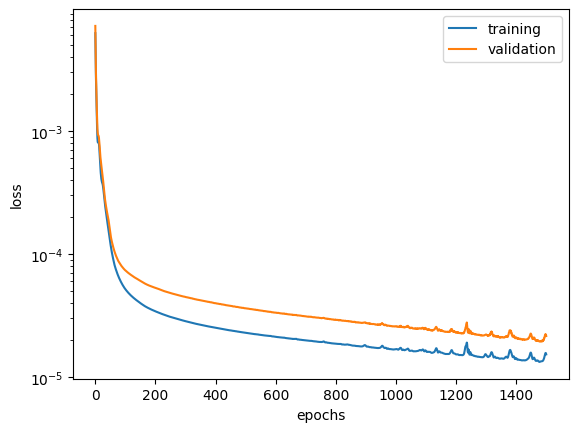

In [ ]:
optimizer = torch.optim.Adam(dynamics.parameters(), lr=0.01)

# Split dataset into training and validation
train_ratio = 0.7
train_data, validation_data = data[:int(train_ratio * len(data))], \
                              data[int(train_ratio * len(data)):]

def compute_loss(model, data_t, loss_func = torch.nn.MSELoss()):
   

def transpose_batch(batch):
    

def train(model, train_data, validation_data, epochs=1500):
    """
    Training code here
    """
    # Plot losses
    plt.plot(losses)
    plt.yscale("log")
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.legend(["training", "validation"])
    plt.show()

train(dynamics, data, validation_data)

## Visualize trained dynamics

In order to qualitatively evaluate our model, we can choose some values of steering angle *(right, center, left)* and acceleration *(slow, fast)* in order to predict and visualize the corresponding trajectories from an initial state.  


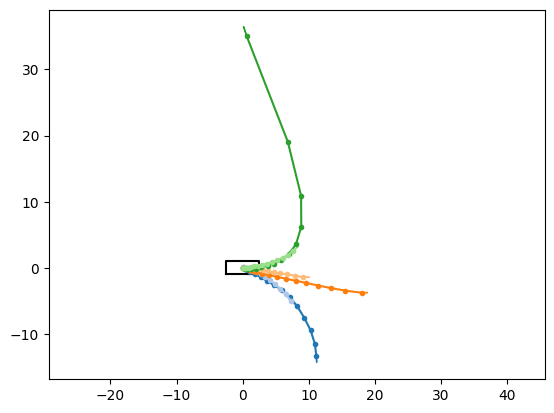

In [ ]:
def predict_trajectory(state, actions, model, action_repeat=1):
    states = []
    for action in actions:
        for _ in range(action_repeat):
            state = model(state, action)
            states.append(state)
    return torch.stack(states, dim=0)

def plot_trajectory(states, color):
    scales = np.array(highway_env.envs.parking_env.ParkingEnv.default_config()["observation"]["scales"])
    states = np.clip(states.squeeze(1).detach().numpy() * scales, -100, 100)
    plt.plot(states[:, 0], states[:, 1], color=color, marker='.')
    plt.arrow(states[-1,0], states[-1,1], states[-1,4]*1, states[-1,5]*1, color=color)

def visualize_trajectories(model, state, horizon=15):
    plt.cla()
    # Draw a car
    plt.plot(state.numpy()[0]+2.5*np.array([-1, -1, 1, 1, -1]),
             state.numpy()[1]+1.0*np.array([-1, 1, 1, -1, -1]), 'k')
    # Draw trajectories
    state = state.unsqueeze(0)
    colors = iter(plt.get_cmap("tab20").colors)
    # Generate commands
    for steering in np.linspace(-0.5, 0.5, 3):
        for acceleration in np.linspace(0.8, 0.4, 2):
            actions = torch.Tensor([acceleration, steering]).view(1,1,-1)
            # Predict trajectories
            states = predict_trajectory(state, actions, model, action_repeat=horizon)
            plot_trajectory(states, color=next(colors))
    plt.axis("equal")
    plt.show()

visualize_trajectories(dynamics, state=torch.Tensor([0, 0, 0, 0, 1, 0]))

Do the predicted trajectories look realistic? If not, you can try to:
- Collect more data in $D$
- Increase the model capacity (size of hidden layer, number of layers)
- Increase the number of training epochs or change the learning rate
- Add regularization
## Reward model
We assume that the reward $R(s,a)$ is known (chosen by the system designer), and takes the form of a **weighted L1-norm** between the state and the goal.

In [ ]:
def reward_model(states, goal, gamma=None):
    """
        The reward is a weighted L1-norm between the state and a goal
    :param Tensor states: a batch of states. shape: [batch_size, state_size].
    :param Tensor goal: a goal state. shape: [state_size].
    :param float gamma: a discount factor
    """
    goal = goal.expand(states.shape)
    reward_weigths = torch.Tensor(highway_env.envs.parking_env.ParkingEnv.default_config()["reward_weights"])
    rewards = -torch.pow(torch.norm((states-goal)*reward_weigths, p=1, dim=-1), 0.5)
    if gamma:
        time = torch.arange(rewards.shape[0], dtype=torch.float).unsqueeze(-1).expand(rewards.shape)
        rewards *= torch.pow(gamma, time)
    return rewards

obs = env.reset()[0]
print("Reward of a sample transition:", reward_model(torch.Tensor(obs["observation"]).unsqueeze(0),
                                                     torch.Tensor(obs["desired_goal"])))

Reward of a sample transition: tensor([-0.3540])


## Leverage dynamics model for planning

We now use the learnt dynamics model $f_\theta$ for planning.
In order to solve the optimal control problem, we use a sampling-based optimization algorithm: the **Cross-Entropy Method** (`CEM`). It is an optimization algorithm applicable to problems that are both **combinatorial** and **continuous**, which is our case: find the best performing sequence of actions.

This method approximates the optimal importance sampling estimator by repeating two phases:
1. **Draw samples** from a probability distribution. We use Gaussian distributions over sequences of actions.
2. Minimize the **cross-entropy** between this distribution and a **target distribution** to produce a better sample in the next iteration. We define this target distribution by selecting the top-k performing sampled sequences.

![Credits to Olivier Sigaud](https://github.com/yfletberliac/rlss2019-hands-on/blob/master/imgs/cem.png?raw=1)

Note that as we have a local linear dynamics model, we could instead choose an `Iterative LQR` planner which would be more efficient. We prefer `CEM` in this educational setting for its simplicity and generality.

In [ ]:
def cem_planner(state, goal, action_size, horizon=2, population=20, selection=10, iterations=5):
    


# Run the planner on a sample transition
action = cem_planner(torch.Tensor(obs["observation"]),
                     torch.Tensor(obs["desired_goal"]),
                     env.action_space.shape[0])
assert env.action_space.contains(action.numpy())
print("Planned action:", action)

Planned action: tensor([0.9887, 0.1429])


## Visualize a few episodes

En voiture, Simone !

In [ ]:
env = gym.make("parking-v0", render_mode="rgb_array")
env = RecordVideo(env, 'video_test',  episode_trigger = lambda episode_number: True)
for episode in tnrange(3, desc="Test episodes"):
    obs = env.reset()[0]
    done = False
    while not done:
        action = cem_planner(torch.Tensor(obs["observation"]),
                             torch.Tensor(obs["desired_goal"]),
                             env.action_space.shape[0])
        obs, reward, done, info = env.step(action.numpy())
env.close()

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /content/video_test folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
<ipython-input-21-9905fc18f788>:5: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for episode in tnrange(3, desc="Test episodes"):


Test episodes:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
show_videos("video_test")

Is the performance satisfying?
If not, try to identify if the problem lies with the dynamics model or the planner.
If you think that the planner is at fault, you can try to:
- Increase the size of the population.
- Increase the planning horizon.
- Add action repeat in the planning procedure, in order to increase the effective planning horizon without increasing
  the size of the optimization space (sampled sequences of actions).

## Limits

### Model bias

In model-based reinforcement learning, we replace our original optimal control problem by another problem: optimizing our learnt approximate MDP. When settling for this approximate MDP to plan with, we introduce a **bias** that can only **decrease the true performance** of the corresponding planned policy. This is called the problem of model bias.

In some MDPs, even slight model errors lead to a dramatic drop in performance, as illustrated in the beginning of the following video:

[![Approximate Robust Control of Uncertain Dynamical Systems](https://img.youtube.com/vi/8khqd3BJo0A/0.jpg)](https://www.youtube.com/watch?v=8khqd3BJo0A)

The question of how to address model bias belongs to the field of **Safe Reinforcement Learning**.

### [L'appel du vide](https://www.urbandictionary.com/define.php?term=L%27appel%20du%20vide)

The model will be accurate only on some region of the state space that was explored and covered in $D$.
Outside of $D$, the model may diverge and **hallucinate** important rewards.
This effect is problematic when the model is used by a planning algorithm, as the latter will try to **exploit** these hallucinated high rewards and will steer the agent towards **unknown** (and thus dangerous) **regions** where the model is erroneously optimistic.

### Computational cost of planning

At test time, the planning step typically requires **sampling a lot of trajectories** to find a near-optimal candidate, wich may turn out to be very costly. This may be prohibitive in a high-frequency real-time setting. The **model-free** methods which directly recommend the best action are **much more efficient** in that regard.